In [1]:
import numpy as np
import pandas as pd

import scipy.stats as sts
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_excel('input_data.xlsx')
df.head()

,date,price,level,levels,rooms,area,kitchen_area,geo_lat,geo_lon,building_type,object_type,postal_code,street_id,id_region,house_id
0,2021-01-01,2451300,15,31,1,45015.0,0.0,56.780112,60.699355,0,2,620000.0,NaN,66,1632918.0
1,2021-01-01,1450000,5,5,1,33.0,6.0,44.608154,40.138381,0,0,385000.0,NaN,1,NaN
2,2021-01-01,10700000,4,13,3,85.0,12.0,55.540060,37.725112,3,0,142701.0,242543.0,50,681306.0
3,2021-01-01,3100000,3,5,3,82.0,9.0,44.608154,40.138381,0,0,385000.0,NaN,1,NaN
4,2021-01-01,2500000,2,3,1,30.0,9.0,44.738685,37.713668,3,2,353960.0,439378.0,23,1730985.0


Мы взяли готовый датасет "Russia Real Estate 2021" с kaggle. Эти данные отображают информацию о рынке недвижимости в России в 2021 году. Данный выбор обусловлен интересом к анализу цен на квартиры в Москве, датасет актуален, изначально содержит 15 переменных. При выгрузке данных в Excel файл некоторые значения были отображены в неверном формате (например, даты). Поэтому, уже на этом этапе данные были преобразованы в числовой вид и так загружались в Jupyter notebook.

In [3]:
print(f'Исходная размерность таблицы:{df.shape}')

Исходная размерность таблицы:(1048575, 15)


Видно, что строчек в таблице очень много, поэтому было посчитано количество данных на каждый регион. Кроме того, мы понимаем, что нельзя построить одну модель, описывающую рынок жилья во всей России.

In [4]:
df['id_region'].value_counts()

77    100454
50     83628
23     80729
78     70069
72     58471
       ...  
4        169
6         54
87        16
79         5
83         2
Name: id_region, Length: 86, dtype: int64

Видно, что больше всего данных приходится на 77 регион (Москва), поэтому было принято решение анализировать жилищный рынок Москвы.

In [5]:
df_1 = df[df['id_region'] == 77]
df_1

,date,price,level,levels,rooms,area,kitchen_area,geo_lat,geo_lon,building_type,object_type,postal_code,street_id,id_region,house_id
10,2021-01-01,3350000,1,19,-1,44936.0,2.0,55.778026,37.540147,3,0,123007.0,580339.0,77,2069062.0
36,2021-01-01,30000000,11,22,3,109.0,45061.0,55.702794,37.666153,3,0,115432.0,451495.0,77,1430362.0
38,2021-01-01,22112640,8,29,3,69.8,45088.0,55.834958,37.637378,0,2,129226.0,201942.0,77,1251884.0
140,2021-01-01,7400000,9,9,1,32.3,44962.0,55.766357,37.712868,3,0,111020.0,394412.0,77,2183736.0
150,2021-01-01,3000000,1,5,1,45090.0,2.0,55.740164,37.546994,4,0,121165.0,152778.0,77,2173638.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048521,2021-02-15,20500000,10,25,3,82.0,45160.0,55.589977,37.601196,0,0,117405.0,459781.0,77,2686656.0
1048530,2021-02-15,7900000,4,14,1,38.0,45054.0,55.646405,37.410386,0,0,119620.0,320194.0,77,2495941.0
1048536,2021-02-15,11500000,10,17,1,39.0,44992.0,55.825917,37.598178,2,0,127427.0,495809.0,77,2370839.0
1048550,2021-02-15,8500000,9,19,1,39.0,10.0,55.698917,37.934886,2,0,111674.0,147782.0,77,2615851.0


Перед тем, как перейти к предобраотке данных, опишем переменные:
- __date__ - дата публикации объявления о продаже
- __price__ - цена в рублях, указанная в объявлении
- __level__ - этаж, на котором расположена квартира
- __levels__ - количество этажей в доме
- __rooms__ - число жилых комнат (если -1, то это квартира-студия)
- __area__ - полная площадь квартиры
- __kitchen_area__ - площадь кухни
- __geo_lat__ - географическая широта
- __geo_lon__ - географическая долгота
- __building_type__ - качественная переменная, обозначающая материал дома. Расшифровка: 0 - неизвестно, 1 - другой, 2 - панельный дом, 3 - монолитный дом, 4 - кирпич, 5 - блочный, 6 - дерево
- __object_type__ - качественная переменная, обозначающая тип апартаментов. Расшифровка: 0 - вторичное жилье, 2 - первичное жилье
- __postal_code__ - почтовый индекс
- __street_id__ - ID улицы
- __id_region__ - код региона
- __house_id__ - ID дома

Уже при выгрузке данных было видно, что в столбцах street_id и house_id были пропуски, кроме того, на сайте не было должного описания этих переменных. Поэтому мы приняли решение удалить их из таблицы. Также подверглись удалению столбцы с широтой и долготой, так как их анализ предполагает наличие географических знаний и разметки карты Москвы. 

In [6]:
df_new= df_1.drop(['geo_lat', 'geo_lon','street_id','house_id'], axis=1)
df_new

,date,price,level,levels,rooms,area,kitchen_area,building_type,object_type,postal_code,id_region
10,2021-01-01,3350000,1,19,-1,44936.0,2.0,3,0,123007.0,77
36,2021-01-01,30000000,11,22,3,109.0,45061.0,3,0,115432.0,77
38,2021-01-01,22112640,8,29,3,69.8,45088.0,0,2,129226.0,77
140,2021-01-01,7400000,9,9,1,32.3,44962.0,3,0,111020.0,77
150,2021-01-01,3000000,1,5,1,45090.0,2.0,4,0,121165.0,77
...,...,...,...,...,...,...,...,...,...,...,...
1048521,2021-02-15,20500000,10,25,3,82.0,45160.0,0,0,117405.0,77
1048530,2021-02-15,7900000,4,14,1,38.0,45054.0,0,0,119620.0,77
1048536,2021-02-15,11500000,10,17,1,39.0,44992.0,2,0,127427.0,77
1048550,2021-02-15,8500000,9,19,1,39.0,10.0,2,0,111674.0,77


Есть две переменные со схожим названием, из-за чего может возникнуть путаница, поэтому level мы переименовали в floor, а levels - в n_floors.

In [7]:
df_new.rename(columns = {'level':'floor', 'levels':'n_floors'}, inplace = True )
df_new

,date,price,floor,n_floors,rooms,area,kitchen_area,building_type,object_type,postal_code,id_region
10,2021-01-01,3350000,1,19,-1,44936.0,2.0,3,0,123007.0,77
36,2021-01-01,30000000,11,22,3,109.0,45061.0,3,0,115432.0,77
38,2021-01-01,22112640,8,29,3,69.8,45088.0,0,2,129226.0,77
140,2021-01-01,7400000,9,9,1,32.3,44962.0,3,0,111020.0,77
150,2021-01-01,3000000,1,5,1,45090.0,2.0,4,0,121165.0,77
...,...,...,...,...,...,...,...,...,...,...,...
1048521,2021-02-15,20500000,10,25,3,82.0,45160.0,0,0,117405.0,77
1048530,2021-02-15,7900000,4,14,1,38.0,45054.0,0,0,119620.0,77
1048536,2021-02-15,11500000,10,17,1,39.0,44992.0,2,0,127427.0,77
1048550,2021-02-15,8500000,9,19,1,39.0,10.0,2,0,111674.0,77


Таблица выглядит неопрятно с  индексами не по порядку, поэтому проведем  переиндексацию:

In [8]:
df_new.reset_index(drop = True, inplace = True)
df_new

,date,price,floor,n_floors,rooms,area,kitchen_area,building_type,object_type,postal_code,id_region
0,2021-01-01,3350000,1,19,-1,44936.0,2.0,3,0,123007.0,77
1,2021-01-01,30000000,11,22,3,109.0,45061.0,3,0,115432.0,77
2,2021-01-01,22112640,8,29,3,69.8,45088.0,0,2,129226.0,77
3,2021-01-01,7400000,9,9,1,32.3,44962.0,3,0,111020.0,77
4,2021-01-01,3000000,1,5,1,45090.0,2.0,4,0,121165.0,77
...,...,...,...,...,...,...,...,...,...,...,...
100449,2021-02-15,20500000,10,25,3,82.0,45160.0,0,0,117405.0,77
100450,2021-02-15,7900000,4,14,1,38.0,45054.0,0,0,119620.0,77
100451,2021-02-15,11500000,10,17,1,39.0,44992.0,2,0,127427.0,77
100452,2021-02-15,8500000,9,19,1,39.0,10.0,2,0,111674.0,77


Для дальнейшей работы очень важно знать, сколько пропусков содержат данные.

In [9]:
df_new.isnull().sum()

date                 0
price                0
floor                0
n_floors             0
rooms                0
area                 0
kitchen_area         0
building_type        0
object_type          0
postal_code      15129
id_region            0
dtype: int64

Видно, что ни в одной переменной нет пропусков, кроме почтового индекса. Так как мы в дальнейшем хотим работать со значениями данной переменной, удалим все строчки, содержащие пропуски в почтовом индексе.

In [25]:
df_2 = df_new.dropna()

Переведем значение почтового индекса в строку, предварительно переведя его в целое число.

In [26]:
df_2['postal_code'] = df_2['postal_code'].astype(int)
df_2

C:\Users\79150\AppData\Local\Temp/ipykernel_8860/2736058030.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['postal_code'] = df_2['postal_code'].astype(int)


,date,price,floor,n_floors,rooms,area,kitchen_area,building_type,object_type,postal_code,id_region
0,2021-01-01,3350000,1,19,-1,44936.0,2.0,3,0,123007,77
1,2021-01-01,30000000,11,22,3,109.0,45061.0,3,0,115432,77
2,2021-01-01,22112640,8,29,3,69.8,45088.0,0,2,129226,77
3,2021-01-01,7400000,9,9,1,32.3,44962.0,3,0,111020,77
4,2021-01-01,3000000,1,5,1,45090.0,2.0,4,0,121165,77
...,...,...,...,...,...,...,...,...,...,...,...
100449,2021-02-15,20500000,10,25,3,82.0,45160.0,0,0,117405,77
100450,2021-02-15,7900000,4,14,1,38.0,45054.0,0,0,119620,77
100451,2021-02-15,11500000,10,17,1,39.0,44992.0,2,0,127427,77
100452,2021-02-15,8500000,9,19,1,39.0,10.0,2,0,111674,77


In [27]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85325 entries, 0 to 100453
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           85325 non-null  datetime64[ns]
 1   price          85325 non-null  int64         
 2   floor          85325 non-null  int64         
 3   n_floors       85325 non-null  int64         
 4   rooms          85325 non-null  int64         
 5   area           85325 non-null  float64       
 6   kitchen_area   85325 non-null  float64       
 7   building_type  85325 non-null  int64         
 8   object_type    85325 non-null  int64         
 9   postal_code    85325 non-null  int32         
 10  id_region      85325 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(7)
memory usage: 7.5 MB


In [28]:
df_2['postal_code'] = df_2['postal_code'].map(int)
df_2

C:\Users\79150\AppData\Local\Temp/ipykernel_8860/3216042433.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['postal_code'] = df_2['postal_code'].map(int)


,date,price,floor,n_floors,rooms,area,kitchen_area,building_type,object_type,postal_code,id_region
0,2021-01-01,3350000,1,19,-1,44936.0,2.0,3,0,123007,77
1,2021-01-01,30000000,11,22,3,109.0,45061.0,3,0,115432,77
2,2021-01-01,22112640,8,29,3,69.8,45088.0,0,2,129226,77
3,2021-01-01,7400000,9,9,1,32.3,44962.0,3,0,111020,77
4,2021-01-01,3000000,1,5,1,45090.0,2.0,4,0,121165,77
...,...,...,...,...,...,...,...,...,...,...,...
100449,2021-02-15,20500000,10,25,3,82.0,45160.0,0,0,117405,77
100450,2021-02-15,7900000,4,14,1,38.0,45054.0,0,0,119620,77
100451,2021-02-15,11500000,10,17,1,39.0,44992.0,2,0,127427,77
100452,2021-02-15,8500000,9,19,1,39.0,10.0,2,0,111674,77


Создадим переменные, содержащие индексы округов Москвы. 
Источник: https://vk.com/away.php?to=http%3A%2F%2Fwww.mapofmoscow.ru%2Findexy.html&cc_key=

In [29]:
central = [121069, 121099,103062, 103064, 103070, 103084, 103097, 103132, 103175, 103289, 107005, 107066, 107078, 107082, 107120, 107262, 109210,103134, 109017, 109072, 109180, 113035, 113054, 113093, 113177, 113184, 113324, 113326, 117049,117325,103012,103045, 103450, 107139, 107140, 107174, 107217, 107228, 107245,103031, 129010, 129090, 129110, 129272,103001, 103025, 103104, 103274, 103379, 121002, 121019, 121205, 123022, 123056, 123100, 123242, 123286, 123290, 123317, 123557, 123610,103006, 103009, 103030, 103032, 103050, 103051, 103055, 103159, 103473, 121059, 125047, 125267,103006, 103009, 103030, 103032, 103050, 103051, 103055, 103159, 103473, 121059, 125047, 125267,119021, 119034, 119048, 119121, 119146, 119270, 119435, 121200]
north = [125083, 125167, 125190, 125315, 125319,123007, 125040, 125124, 125137, 125284,	127247, 127411, 127486, 127644,127599,127474, 127540, 127591,125413, 125438, 125493, 125499, 125565,103031, 125206, 125422, 127434, 127550, 117133,127412,125008, 125183, 125239, 125299,125195, 125445, 125475,127238125239, 125299, 125130, 125171, 125212,125057, 125080, 125252,103220, 103287, 125015, 127018,125413, 125414, 125475, 125502, 125581,123007, 125284, 125468, 123103]
north_east = [129272, 129164, 129278, 129301, 129366, 129626,127410,129281, 129344,	127349, 127543, 127549, 127560,103055, 125047, 103220, 127254, 127322,127253, 127572, 127576,129327, 129336, 129345, 129346,127106, 127276, 127427,129594,129075, 129085, 129515,127273, 127490, 127562, 127566,129128, 129223, 129226, 129256,129323, 129329, 129343,129224, 129282,125195, 127490, 127566, 127204,127018, 127521,129081, 129221, 129642,107140, 129164, 129337, 129338, 129347, 129348]
east = [107150, 107370, 107564, 111395, 111402, 111538, 111539, 109456, 105077, 105203, 107143, 107241, 107497, 107589, 111531, 111555, 111578,105037, 105043, 105173, 105264, 105554, 111621, 111622, 111625, 111672,111394, 111396, 111399, 111558,107258,111123, 111141, 111397, 111398, 111401, 111524,105122, 105215, 105425, 105484, 105523, 107065, 107207,105058, 105118, 105187, 105275, 105318, 105679,107014, 107076, 107113,105023, 107061, 107392, 107553,105568]
south = [113546, 115372, 115404, 115492, 115547, 115598,113403,115408, 115612,113556, 113638, 113639, 115230,113162, 113191, 117419,117071,113105, 113152,	115573, 115580, 115682, 115583,115304, 115477, 115516, 115541,115409, 115446, 115478, 115522,115487, 115533,115142, 115407, 115470,115551, 115569,115561, 115582, 115583, 115597,113054, 113177, 113114,109044, 109316, 109280, 109428, 109088,113587, 113648,113208, 113519, 113525, 113570,113405, 113534, 113535, 113545]
south_east = [109444, 109472, 109507, 109542,109145,109429, 109649,109117, 109378, 109439, 109443, 109462,105275, 105094, 105229, 109033, 111020, 111024, 111116, 111250,109382, 109386, 109559,129594, 127018, 127521, 109369, 109651, 109652,109052, 109391,109235, 109383, 109388, 109548,109377, 109428, 109456, 109457,109125, 109129, 109263, 109387, 109390, 109518,109088, 109193, 109432]
south_west = [117036, 117218, 117292, 117449,103027,121002, 121019, 119034, 117296, 117333, 117334,113149, 113209, 113303, 113452, 113461,117279, 117342, 117437, 117647,113186, 113447,117296, 117119, 117261, 117311, 117331, 117330, 117192,113042, 113628,117133, 117321, 117465,117036, 117218, 117449, 113447, 117261, 117246, 117335, 117418, 117420,113623,117463, 117574, 117588, 117593]
west = [121087, 121096, 121309, 121601,117334, 117330, 119136, 119285, 119590,121151, 121165, 121170, 121248, 121293,121500, 121609, 121614, 121552,121351, 121356, 121359, 121467, 121552, 121374,119501, 119517,121059, 121151, 121165, 121291, 121353, 121354, 121374, 121471, 121596,117602,119530,117192, 117607,117297, 119332, 119618, 119619, 119620, 119633,117526, 117571,117296, 117333, 117330, 117454, 117415, 117606,121019, 121087, 121108, 121352, 121358, 121433]
north_west = [123627,123362, 123367, 123182,123373, 123459, 123480, 123481,123458, 123631, 123154,123103, 123154, 123308, 123423, 123585,123060, 123098, 123182, 123298, 123479,123363, 123364, 123371]

In [30]:
df_2['district'] = np.zeros(85325)
df_2.reset_index(drop = True, inplace = True)
df_2

C:\Users\79150\AppData\Local\Temp/ipykernel_8860/2526896579.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['district'] = np.zeros(85325)


,date,price,floor,n_floors,rooms,area,kitchen_area,building_type,object_type,postal_code,id_region,district
0,2021-01-01,3350000,1,19,-1,44936.0,2.0,3,0,123007,77,0.0
1,2021-01-01,30000000,11,22,3,109.0,45061.0,3,0,115432,77,0.0
2,2021-01-01,22112640,8,29,3,69.8,45088.0,0,2,129226,77,0.0
3,2021-01-01,7400000,9,9,1,32.3,44962.0,3,0,111020,77,0.0
4,2021-01-01,3000000,1,5,1,45090.0,2.0,4,0,121165,77,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
85320,2021-02-15,20500000,10,25,3,82.0,45160.0,0,0,117405,77,0.0
85321,2021-02-15,7900000,4,14,1,38.0,45054.0,0,0,119620,77,0.0
85322,2021-02-15,11500000,10,17,1,39.0,44992.0,2,0,127427,77,0.0
85323,2021-02-15,8500000,9,19,1,39.0,10.0,2,0,111674,77,0.0


In [31]:
for i in range(85325):
    if df_2['postal_code'][i] in central:
        df_2['district'][i] = 'ЦАО'
    elif df_2['postal_code'][i] in north:
        df_2['district'][i] = 'САО'
    elif df_2['postal_code'][i] in north_east:
         df_2['district'][i] = 'СВАО'
    elif df_2['postal_code'][i] in east:
        df_2['district'][i] = 'ВАО'
    elif df_2['postal_code'][i] in south:
        df_2['district'][i] = 'ЮАО'
    elif df_2['postal_code'][i] in south_east:
        df_2['district'][i] = 'ЮВАО'
    elif df_2['postal_code'][i] in south_west:
        df_2['district'][i] = 'ЮЗАО'
    elif df_2['postal_code'][i] in west:
        df_2['district'][i] = 'ЗАО'
    elif df_2['postal_code'][i] in north_west:
        df_2['district'][i] = 'СЗАО'
    else:
        df_2['district'][i] = '-'
df_2

C:\Users\79150\AppData\Local\Temp/ipykernel_8860/3428229536.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['district'][i] = 'САО'
C:\Users\79150\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\79150\anaconda3\lib\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_u

,date,price,floor,n_floors,rooms,area,kitchen_area,building_type,object_type,postal_code,id_region,district
0,2021-01-01,3350000,1,19,-1,44936.0,2.0,3,0,123007,77,САО
1,2021-01-01,30000000,11,22,3,109.0,45061.0,3,0,115432,77,-
2,2021-01-01,22112640,8,29,3,69.8,45088.0,0,2,129226,77,СВАО
3,2021-01-01,7400000,9,9,1,32.3,44962.0,3,0,111020,77,ЮВАО
4,2021-01-01,3000000,1,5,1,45090.0,2.0,4,0,121165,77,ЗАО
...,...,...,...,...,...,...,...,...,...,...,...,...
85320,2021-02-15,20500000,10,25,3,82.0,45160.0,0,0,117405,77,-
85321,2021-02-15,7900000,4,14,1,38.0,45054.0,0,0,119620,77,ЗАО
85322,2021-02-15,11500000,10,17,1,39.0,44992.0,2,0,127427,77,СВАО
85323,2021-02-15,8500000,9,19,1,39.0,10.0,2,0,111674,77,-


In [32]:
df_2['district'].value_counts()

-       47118
САО      6141
ЗАО      5925
СВАО     5497
ВАО      4858
ЦАО      4608
ЮВАО     4277
ЮАО      3813
СЗАО     1729
ЮЗАО     1359
Name: district, dtype: int64

Мы нашли единственный удобный источник данных по московским почтовым индексам, но, судя по количеству пропусков в таблице, этой информации недостаточно (или она не достаточно актуальна). Но это не проблема, так как наблюдений достаточно много и мы можем исследовать те, для которых известен округ.

In [33]:
our_df = df_2.loc[df_2['district'] != '-']
our_df

,date,price,floor,n_floors,rooms,area,kitchen_area,building_type,object_type,postal_code,id_region,district
0,2021-01-01,3350000,1,19,-1,44936.0,2.0,3,0,123007,77,САО
2,2021-01-01,22112640,8,29,3,69.8,45088.0,0,2,129226,77,СВАО
3,2021-01-01,7400000,9,9,1,32.3,44962.0,3,0,111020,77,ЮВАО
4,2021-01-01,3000000,1,5,1,45090.0,2.0,4,0,121165,77,ЗАО
5,2021-01-01,25173570,19,22,2,90.5,0.0,0,2,121170,77,ЗАО
...,...,...,...,...,...,...,...,...,...,...,...,...
85315,2021-02-15,10400000,4,9,1,35.0,44967.0,0,0,121351,77,ЗАО
85317,2021-02-15,19800000,3,9,2,44.2,0.0,0,0,121248,77,ЗАО
85321,2021-02-15,7900000,4,14,1,38.0,45054.0,0,0,119620,77,ЗАО
85322,2021-02-15,11500000,10,17,1,39.0,44992.0,2,0,127427,77,СВАО


In [34]:
our_df.reset_index(drop = True, inplace = True)

In [35]:
our_df

,date,price,floor,n_floors,rooms,area,kitchen_area,building_type,object_type,postal_code,id_region,district
0,2021-01-01,3350000,1,19,-1,44936.0,2.0,3,0,123007,77,САО
1,2021-01-01,22112640,8,29,3,69.8,45088.0,0,2,129226,77,СВАО
2,2021-01-01,7400000,9,9,1,32.3,44962.0,3,0,111020,77,ЮВАО
3,2021-01-01,3000000,1,5,1,45090.0,2.0,4,0,121165,77,ЗАО
4,2021-01-01,25173570,19,22,2,90.5,0.0,0,2,121170,77,ЗАО
...,...,...,...,...,...,...,...,...,...,...,...,...
38202,2021-02-15,10400000,4,9,1,35.0,44967.0,0,0,121351,77,ЗАО
38203,2021-02-15,19800000,3,9,2,44.2,0.0,0,0,121248,77,ЗАО
38204,2021-02-15,7900000,4,14,1,38.0,45054.0,0,0,119620,77,ЗАО
38205,2021-02-15,11500000,10,17,1,39.0,44992.0,2,0,127427,77,СВАО


На этом мы закончили предобработку данных.

Начнем визуализировать данные:

Для начала проверим, зависит ли цена квартиры от ее площади.

Text(0.5, 1.0, 'Точечная диаграмма зависимости цен на квартиры в Москве от их площади')

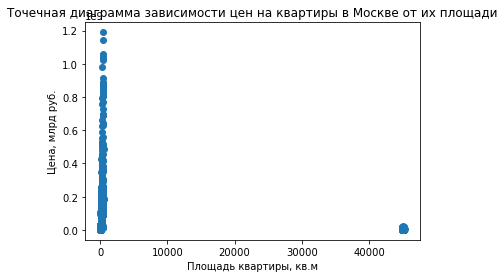

In [36]:
plt.scatter(our_df['area'], our_df['price'],)
plt.xlabel("Площадь квартиры, кв.м")
plt.ylabel("Цена, млрд руб.")
plt.title('Точечная диаграмма зависимости цен на квартиры в Москве от их площади')

Видим выбросы, которые соответствуют каким-то неточностям в исходных данных. Удалим все квартиры, чья площадь, согласно таблице, больше 750 квадратных метров.

In [37]:
our_df[our_df['area']>750]

,date,price,floor,n_floors,rooms,area,kitchen_area,building_type,object_type,postal_code,id_region,district
0,2021-01-01,3350000,1,19,-1,44936.0,2.0,3,0,123007,77,САО
3,2021-01-01,3000000,1,5,1,45090.0,2.0,4,0,121165,77,ЗАО
10,2021-01-01,7275600,14,16,1,45067.0,-100.0,0,2,115583,77,ЮАО
22,2021-01-01,5462520,8,33,-1,45096.0,5.0,2,2,107553,77,ВАО
34,2021-01-01,7888000,12,14,1,44984.0,45113.0,2,2,121552,77,ЗАО
...,...,...,...,...,...,...,...,...,...,...,...,...
38057,2021-02-15,6569640,8,22,-1,44952.0,-100.0,3,2,127486,77,САО
38081,2021-02-15,5442600,4,25,-1,44985.0,-100.0,3,2,127576,77,СВАО
38168,2021-02-15,3650000,1,5,-1,44998.0,-100.0,4,0,123022,77,ЦАО
38183,2021-02-15,8045786,19,23,-1,45015.0,-100.0,3,2,109428,77,ЮАО


In [38]:
our_df1 = our_df.loc[our_df['area'] < 750]
our_df1

,date,price,floor,n_floors,rooms,area,kitchen_area,building_type,object_type,postal_code,id_region,district
1,2021-01-01,22112640,8,29,3,69.8,45088.0,0,2,129226,77,СВАО
2,2021-01-01,7400000,9,9,1,32.3,44962.0,3,0,111020,77,ЮВАО
4,2021-01-01,25173570,19,22,2,90.5,0.0,0,2,121170,77,ЗАО
5,2021-01-01,10503090,17,31,1,42.3,45028.0,3,2,107392,77,ВАО
6,2021-01-01,6418000,21,32,-1,20.0,5.0,3,2,107392,77,ВАО
...,...,...,...,...,...,...,...,...,...,...,...,...
38202,2021-02-15,10400000,4,9,1,35.0,44967.0,0,0,121351,77,ЗАО
38203,2021-02-15,19800000,3,9,2,44.2,0.0,0,0,121248,77,ЗАО
38204,2021-02-15,7900000,4,14,1,38.0,45054.0,0,0,119620,77,ЗАО
38205,2021-02-15,11500000,10,17,1,39.0,44992.0,2,0,127427,77,СВАО


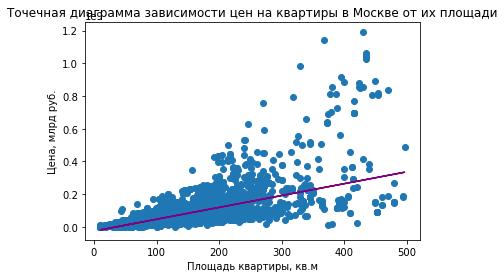

In [39]:
plt.scatter(our_df1['area'],our_df1['price'])
plt.xlabel("Площадь квартиры, кв.м")
plt.ylabel("Цена, млрд руб.");
z = np.polyfit (our_df1['area'], our_df1['price'], 1 )
p = np.poly1d (z)
plt.plot (our_df1['area'], p(our_df1['area']),color = 'purple')
plt.title('Точечная диаграмма зависимости цен на квартиры в Москве от их площади')
plt.show()

Видно положительный тренд.

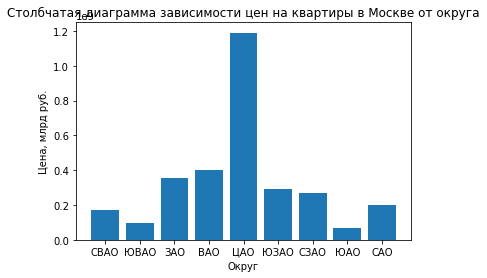

In [40]:
plt.bar(our_df1['district'],our_df1['price'])
plt.xlabel("Округ")
plt.ylabel("Цена, млрд руб.")
plt.title('Столбчатая диаграмма зависимости цен на квартиры в Москве от округа')
plt.show()

<BarContainer object of 35679 artists>

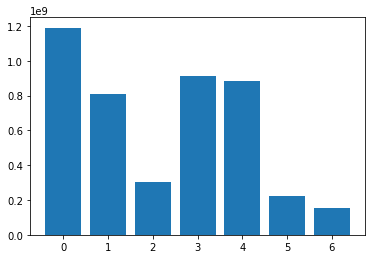

In [41]:
plt.bar(our_df1['building_type'],our_df1['price'])

Самые дорогие квартиры находятся в домах нулевого типа, который соответствует неизвестному материалу дома. Кроме того, первый тип тоже неидентифицируемый. 

Так как у нас есть 3 категориальные переменные, то необходимо будет сделать OHE, следовательно, будет очень много дополнительных колонок, что в дальнейшем может помешать машинному обучению. Информация о материале дома может быть частично заложена в другие переменные, например, в число этажей. Тем более, результаты, полученные с использованием данной переменной, будет трудно интерпретировать ("неизвестный" материал - это что?). Поэтому мы решили удалить эту переменную.

In [42]:
our_df1.drop('building_type',axis= 1, inplace = True)

C:\Users\79150\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [43]:
our_df1

,date,price,floor,n_floors,rooms,area,kitchen_area,object_type,postal_code,id_region,district
1,2021-01-01,22112640,8,29,3,69.8,45088.0,2,129226,77,СВАО
2,2021-01-01,7400000,9,9,1,32.3,44962.0,0,111020,77,ЮВАО
4,2021-01-01,25173570,19,22,2,90.5,0.0,2,121170,77,ЗАО
5,2021-01-01,10503090,17,31,1,42.3,45028.0,2,107392,77,ВАО
6,2021-01-01,6418000,21,32,-1,20.0,5.0,2,107392,77,ВАО
...,...,...,...,...,...,...,...,...,...,...,...
38202,2021-02-15,10400000,4,9,1,35.0,44967.0,0,121351,77,ЗАО
38203,2021-02-15,19800000,3,9,2,44.2,0.0,0,121248,77,ЗАО
38204,2021-02-15,7900000,4,14,1,38.0,45054.0,0,119620,77,ЗАО
38205,2021-02-15,11500000,10,17,1,39.0,44992.0,0,127427,77,СВАО


Text(0.5, 1.0, 'Столбчатая диаграмма зависимости цен на квартиры в Москве от их типа')

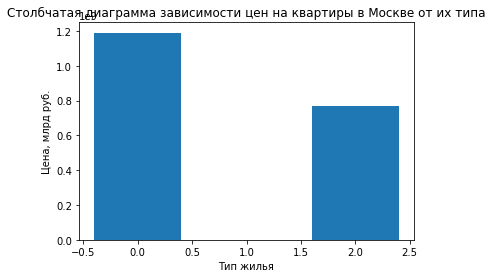

In [44]:
plt.bar(our_df1['object_type'],our_df1['price'])
plt.xlabel("Тип жилья")
plt.ylabel("Цена, млрд руб.")
plt.title('Столбчатая диаграмма зависимости цен на квартиры в Москве от их типа')

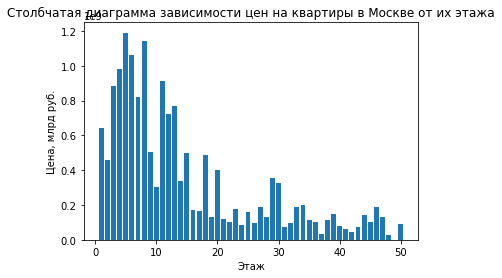

In [45]:
plt.bar(our_df1['floor'],our_df1['price'])
plt.xlabel("Этаж")
plt.ylabel("Цена, млрд руб.")
plt.title('Столбчатая диаграмма зависимости цен на квартиры в Москве от их этажа')
plt.show()

Видим, что есть тенденция к уменьшению стоимости квартиры с увеличением этажа, на котором она расположена. Предположительно, наиболее дорогие квартиры расположены в центре Москвы (сталинки). 

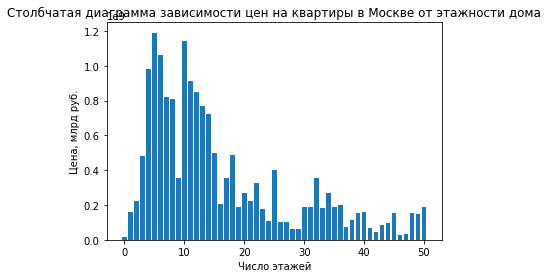

In [46]:
plt.bar(our_df1['n_floors'],our_df1['price'])
plt.xlabel("Число этажей")
plt.ylabel("Цена, млрд руб.")
plt.title('Столбчатая диаграмма зависимости цен на квартиры в Москве от этажности дома')
plt.show()

Наиболее дорогие квартиры расположены в малоэтажных домах.

In [47]:
our_df1.corr().style.background_gradient(cmap = 'RdYlGn')

C:\Users\79150\anaconda3\lib\site-packages\pandas\io\formats\style.py:2813: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
C:\Users\79150\anaconda3\lib\site-packages\pandas\io\formats\style.py:2814: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,price,floor,n_floors,rooms,area,kitchen_area,object_type,postal_code,id_region
price,1.000000,0.019912,-0.040335,0.421065,0.729859,-0.111416,-0.059457,0.075963,nan
floor,0.019912,1.000000,0.616173,0.061236,0.102776,0.063698,0.289048,0.040954,nan
n_floors,-0.040335,0.616173,1.000000,0.010957,0.079134,0.080050,0.439908,0.060216,nan
rooms,0.421065,0.061236,0.010957,1.000000,0.742687,-0.028255,-0.047979,0.064472,nan
area,0.729859,0.102776,0.079134,0.742687,1.000000,-0.105609,-0.010430,0.112710,nan
kitchen_area,-0.111416,0.063698,0.080050,-0.028255,-0.105609,1.000000,0.187943,-0.073437,nan
object_type,-0.059457,0.289048,0.439908,-0.047979,-0.010430,0.187943,1.000000,-0.024354,nan
postal_code,0.075963,0.040954,0.060216,0.064472,0.112710,-0.073437,-0.024354,1.000000,nan
id_region,nan,nan,nan,nan,nan,nan,nan,nan,nan


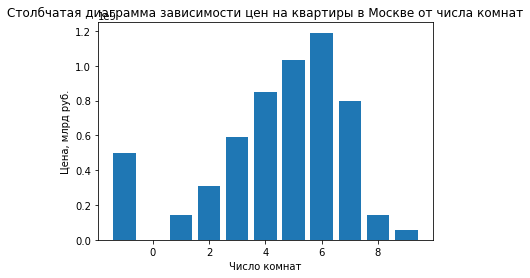

In [48]:
plt.bar(our_df1['rooms'],our_df1['price'])
plt.xlabel("Число комнат")
plt.ylabel("Цена, млрд руб.")
plt.title('Столбчатая диаграмма зависимости цен на квартиры в Москве от числа комнат')
plt.show()

Интересно, что студии стоят дороже, чем однокомнатные и двухкомнатные квартиры.

## Гипотезы

- площадь влияет на цену (H0: коэф. коррел. = 0)
- разница матожиданий стоимостей квартир в ЗАО и ВАО,ЮЗАО и СЗАО равна нулю (Н0: $\mu_1$ = $\mu_2$, используем ttest)
- первичное жилье дороже вторичного (H0: $\mu_1$ = $\mu_2$, H1: $\mu_1$ > $\mu_2$)
- квартиры в малоэтажных домах дороже (до 15 этажа) (H0: 
- студии дороже, чем однокомнатные и двухкомнатные квартиры (отдельно сравним МО однокомнатных квартир и МО двухкомнатных квартир с МО студии)

Мы собираемся использовать для предсказания цены модель машинного обучения линейной регрессии. Предварительно сделаем OHE, введя дамми-переменные, и стандартизируем числовые переменные.